In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular.all import *
import betting.feature_engineering as features

# Kaggle analysis

## Data preparation

In [3]:
data_dir = Path('../data/kaggle')
data_dir.ls()

(#3) [Path('../data/kaggle/.ipynb_checkpoints'),Path('../data/kaggle/closing_odds.feather'),Path('../data/kaggle/closed_preprocess.feather')]

In [4]:
raw_df = pd.read_feather(data_dir/'closing_odds.feather')
raw_df.head()

,match_id,league,match_date,home_team,home_score,away_team,away_score,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,max_odds_home_win,max_odds_draw,max_odds_away_win
0,170088,England: Premier League,2005-01-01,Liverpool,0,Chelsea,1,2.9944,3.1944,2.2256,3.20,3.25,2.29
1,170125,England: League Two,2005-01-01,Lincoln City,1,Bury,0,1.8667,3.2222,3.6922,1.91,3.30,3.93
2,170126,England: League Two,2005-01-01,Macclesfield,1,Chester,2,1.7822,3.3000,4.0000,1.85,3.50,4.34
3,170127,England: League Two,2005-01-01,Oxford Utd,2,Wycombe,1,2.3122,3.1967,2.7067,2.38,3.27,2.85
4,170128,England: League Two,2005-01-01,Scunthorpe,0,Darlington,1,1.6411,3.3922,4.7078,1.67,3.50,5.50


In [5]:
raw_df['result'] = features.results_from_goals(raw_df, 'home_score', 'away_score')

## Odds only

To see if this method is viable at all we'll use the maximum odds for betting.

In [6]:
odds_df = pd.DataFrame()

odds_df['x_home'] = raw_df.max_odds_home_win
odds_df['x_draw'] = raw_df.max_odds_draw
odds_df['x_away'] = raw_df.max_odds_away_win

odds_df = odds_df.merge(features.create_profit_df(raw_df, 'max_odds_home_win', 'max_odds_draw', 'max_odds_away_win'),
                        left_index=True, right_index=True)

#odds_df['y_none'] = 0
odds_df.head()

,x_home,x_draw,x_away,y_home,y_draw,y_away
0,3.20,3.25,2.29,-1.00,-1.0,1.29
1,1.91,3.30,3.93,0.91,-1.0,-1.00
2,1.85,3.50,4.34,-1.00,-1.0,3.34
3,2.38,3.27,2.85,1.38,-1.0,-1.00
4,1.67,3.50,5.50,-1.00,-1.0,4.50


### Add league info

Due to a bug(?) in fastai we need at least one categorical column for the model to work, so we'll add the league name and the country (or 'category' in case of 'world' and 'europe').

In [7]:
league_df = raw_df.league.str.split(pat=': ', expand=True)
league_df.columns = ['country', 'league']

In [8]:
odds_df['country'] = league_df.country
odds_df['league'] = league_df.league

In [9]:
odds_df.head()

,x_home,x_draw,x_away,y_home,y_draw,y_away,country,league
0,3.20,3.25,2.29,-1.00,-1.0,1.29,England,Premier League
1,1.91,3.30,3.93,0.91,-1.0,-1.00,England,League Two
2,1.85,3.50,4.34,-1.00,-1.0,3.34,England,League Two
3,2.38,3.27,2.85,1.38,-1.0,-1.00,England,League Two
4,1.67,3.50,5.50,-1.00,-1.0,4.50,England,League Two


### Standardization

We want the three input odds to be standardized according to their (total) mean and standard deviation, so we'll do this by hand.

In [10]:
odds_mean = odds_df.iloc[:,:3].values.mean()
odds_std = odds_df.iloc[:,:3].values.std()
print('Odds mean: ', odds_mean)
print('Odds std: ', odds_std)

Odds mean:  3.767972801601869
Odds std:  3.1308143325062425


In [11]:
odds_df.iloc[:, :3] = (odds_df.iloc[:, :3] - odds_mean) / odds_std

odds_df.head()

,x_home,x_draw,x_away,y_home,y_draw,y_away,country,league
0,-0.181414,-0.165443,-0.472073,-1.00,-1.0,1.29,England,Premier League
1,-0.593447,-0.149473,0.051752,0.91,-1.0,-1.00,England,League Two
2,-0.612611,-0.085592,0.182709,-1.00,-1.0,3.34,England,League Two
3,-0.443326,-0.159055,-0.293206,1.38,-1.0,-1.00,England,League Two
4,-0.670105,-0.085592,0.553219,-1.00,-1.0,4.50,England,League Two


### Dataloaders

In [12]:
to = TabularPandas(odds_df, cat_names=['league', 'country'], procs=[Categorify],
                   cont_names = ['x_home', 'x_draw', 'x_away'],
                   y_names=['y_home', 'y_draw', 'y_away'],
                   splits=RandomSplitter(valid_pct=0.2)(range_of(odds_df)))

In [13]:
dls = to.dataloaders(bs=1024)
dls.show_batch()

,league,country,x_home,x_draw,x_away,y_home,y_draw,y_away
0,APL Premier League,Australia,-0.414580,-0.117533,-0.245295,-1.00,-1.00,2.0
1,Torneo Postobon,Colombia,-0.778702,0.585160,1.830842,0.33,-1.00,-1.0
2,Gambrinus liga,Czech Republic,-0.436938,-0.152667,0.010230,-1.00,2.29,-1.0
3,Botola,Morocco,-0.293206,-0.309176,-0.283624,1.85,-1.00,-1.0
4,Super League,Malaysia,-0.404998,-0.181414,-0.181414,-1.00,2.20,-1.0
5,Primera Division,Venezuela,0.137992,-0.101562,-0.551924,-1.00,2.45,-1.0
6,Club Friendly,World,-0.564701,-0.149473,-0.104756,1.00,-1.00,-1.0
7,Club Friendly,World,-0.724404,-0.005741,0.553219,0.50,-1.00,-1.0
8,Oberliga Hamburg,Germany,0.521279,0.122022,-0.724404,-1.00,3.15,-1.0
9,Regionalliga West,Germany,-0.641358,-0.101562,0.249784,0.76,-1.00,-1.0


### Loss function, profit

Applying softmax to the output of the network lets us interpret the values as ratios. These ratios can be understood as the ratio of a fixed amount of money that is bet on one of the outcomes (home win, draw, away win). Multiplying these ratios with the odds(which already have 1 selected to account for the cost of taking the bet) and summing across that row gives the bank roll after the bet.

Optimization algorithms in machine learning usually minimize, so we'll use minus the bank roll as the loss function. More precise: The mean of the bank rolls in the current batch.

When watching the training progress keep in mind that a negative loss is good in this case. Additionally, the actual profit for each batch is shown too (fastai takes the mean across all validation batches?)

In [14]:
def odds_loss(actual, target):
    probs = F.softmax(actual, dim=1)
    return -(probs*target).sum(dim=1).mean()

def odds_profit(actual, target):
    probs = F.softmax(actual, dim=1)
    return (probs*target).sum()

This looked good in first runs, but that was due to a bug. The result now indicates that only having the maximum odds (and the league) is not sufficient to win.

### Better validation, seasons

The easiest way to get better validation data is to transform the dates into seasons. First as string ('0506' for the season 2005/2006) for storage, then as category.

In [15]:
def season_from_row(row):
    date = row.match_date
    if date.month<=7:
        season = date.year-1
    else:
        season = date.year
    return season

In [16]:
season_from_row(raw_df.iloc[0])

2004

In [17]:
raw_df['season'] = raw_df.apply(season_from_row, axis=1)
raw_df.head()

,match_id,league,match_date,home_team,home_score,away_team,away_score,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,max_odds_home_win,max_odds_draw,max_odds_away_win,result,season
0,170088,England: Premier League,2005-01-01,Liverpool,0,Chelsea,1,2.9944,3.1944,2.2256,3.20,3.25,2.29,1,2004
1,170125,England: League Two,2005-01-01,Lincoln City,1,Bury,0,1.8667,3.2222,3.6922,1.91,3.30,3.93,-1,2004
2,170126,England: League Two,2005-01-01,Macclesfield,1,Chester,2,1.7822,3.3000,4.0000,1.85,3.50,4.34,1,2004
3,170127,England: League Two,2005-01-01,Oxford Utd,2,Wycombe,1,2.3122,3.1967,2.7067,2.38,3.27,2.85,-1,2004
4,170128,England: League Two,2005-01-01,Scunthorpe,0,Darlington,1,1.6411,3.3922,4.7078,1.67,3.50,5.50,1,2004


In [18]:
class ColumnNormalizer:
    def __init__(self, column):
        self.mean = column.mean()
        self.std = column.std()
        
    def __call__(self, col):
        return (col-self.mean) / self.std
    
    def __str__(self): return f'Mean: {self.mean} | Std: {self.std}'
    def __repr__(self): return str(self)

In [19]:
season_norm = ColumnNormalizer(raw_df.season)
season_norm

Mean: 2010.4186446687802 | Std: 2.7880621822507554

In [20]:
odds_df['season'] = season_norm(raw_df.season)
odds_df.head()

,x_home,x_draw,x_away,y_home,y_draw,y_away,country,league,season
0,-0.181414,-0.165443,-0.472073,-1.00,-1.0,1.29,England,Premier League,-2.302188
1,-0.593447,-0.149473,0.051752,0.91,-1.0,-1.00,England,League Two,-2.302188
2,-0.612611,-0.085592,0.182709,-1.00,-1.0,3.34,England,League Two,-2.302188
3,-0.443326,-0.159055,-0.293206,1.38,-1.0,-1.00,England,League Two,-2.302188
4,-0.670105,-0.085592,0.553219,-1.00,-1.0,4.50,England,League Two,-2.302188


In [21]:
odds_df['valid'] = raw_df.season>=2013
odds_df.head()

,x_home,x_draw,x_away,y_home,y_draw,y_away,country,league,season,valid
0,-0.181414,-0.165443,-0.472073,-1.00,-1.0,1.29,England,Premier League,-2.302188,False
1,-0.593447,-0.149473,0.051752,0.91,-1.0,-1.00,England,League Two,-2.302188,False
2,-0.612611,-0.085592,0.182709,-1.00,-1.0,3.34,England,League Two,-2.302188,False
3,-0.443326,-0.159055,-0.293206,1.38,-1.0,-1.00,England,League Two,-2.302188,False
4,-0.670105,-0.085592,0.553219,-1.00,-1.0,4.50,England,League Two,-2.302188,False


In [22]:
to = TabularPandas(odds_df, cat_names=['country', 'league'], procs=[Categorify],
                   cont_names = ['x_home', 'x_draw', 'x_away', 'season'],
                   y_names=['y_home', 'y_draw', 'y_away'],
                   splits=ColSplitter('valid')(odds_df))
dls = to.dataloaders(bs=1024)

In [23]:
learn = tabular_learner(dls, loss_func=odds_loss, metrics=odds_profit, layers=[1000, 500, 250, 100, 50])
learn.model = learn.model.to('cuda')

SuggestedLRs(lr_min=0.2754228591918945, lr_steep=0.3019951581954956)

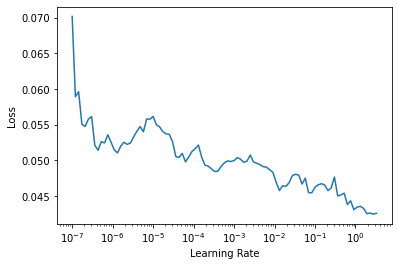

In [24]:
learn.lr_find()

In [25]:
learn.fit_one_cycle(5, lr_max=1e-3)

epoch,train_loss,valid_loss,odds_profit,time
0,0.012114,0.016340,-16.756662,00:06
1,0.023771,0.016735,-17.103012,00:06
2,0.014704,0.004573,-4.690269,00:06
3,-0.001411,0.006576,-6.840491,00:06
4,-0.007962,0.006975,-7.237962,00:06


In [26]:
profit = 0.
for x1,x2,y in dls.valid:
    preds = learn.model(x1,x2)
    profit += odds_profit(preds, y)

print('Total profit on the validation set: ', profit.item())
print('Samples in the validation set: ', len(dls.valid_ds))

Total profit on the validation set:  -954.2088623046875
Samples in the validation set:  136811


In [27]:
save_path = Path('../data/kaggle/closed_preprocess.feather')
odds_df.to_feather(save_path)

## Compare with bookie edge

Bookkeeper incorporate an endge into their betting odds. If there is no systematic error in their odds, a model should not be able to be better than the edge.

In [28]:
odds_cols = ['max_odds_home_win', 'max_odds_draw', 'max_odds_away_win']
probs  = 1/raw_df.loc[:,odds_cols]
probs = probs.replace([np.inf, -np.inf], np.nan).dropna(subset=odds_cols, how="any")
edges = probs.sum(axis=1) - 1

edges.mean()

0.038320276395318265

So betting by using the implied probabilities shouldn't be profitable:

In [29]:
bet_df = pd.DataFrame()

bet_df['x_home'] = raw_df.max_odds_home_win
bet_df['x_draw'] = raw_df.max_odds_draw
bet_df['x_away'] = raw_df.max_odds_away_win

bet_df = bet_df.merge(features.create_profit_df(raw_df, 'max_odds_home_win', 'max_odds_draw', 'max_odds_away_win'),
                        left_index=True, right_index=True)

bet_df.head()

,x_home,x_draw,x_away,y_home,y_draw,y_away
0,3.20,3.25,2.29,-1.00,-1.0,1.29
1,1.91,3.30,3.93,0.91,-1.0,-1.00
2,1.85,3.50,4.34,-1.00,-1.0,3.34
3,2.38,3.27,2.85,1.38,-1.0,-1.00
4,1.67,3.50,5.50,-1.00,-1.0,4.50


In [30]:
bet_df['b_home'] = 1/bet_df.x_home
bet_df['b_draw'] = 1/bet_df.x_draw
bet_df['b_away'] = 1/bet_df.x_away

bet_df = bet_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['b_home', 'b_draw', 'b_away'], how="any")

bet_df.head()

,x_home,x_draw,x_away,y_home,y_draw,y_away,b_home,b_draw,b_away
0,3.20,3.25,2.29,-1.00,-1.0,1.29,0.312500,0.307692,0.436681
1,1.91,3.30,3.93,0.91,-1.0,-1.00,0.523560,0.303030,0.254453
2,1.85,3.50,4.34,-1.00,-1.0,3.34,0.540541,0.285714,0.230415
3,2.38,3.27,2.85,1.38,-1.0,-1.00,0.420168,0.305810,0.350877
4,1.67,3.50,5.50,-1.00,-1.0,4.50,0.598802,0.285714,0.181818


In [31]:
bets = bet_df.loc[:,['b_home', 'b_draw', 'b_away']].values
targets = bet_df.loc[:, ['y_home', 'y_draw', 'y_away']].values

(bets*targets).mean(), (bets*targets).sum()

(-0.012773425465106089, -18370.280660598833)

## With average odds

Adding the average odds to the dataset should help the model.

In [32]:
try:
    odds_df.drop(columns=['x_home', 'x_draw', 'x_away'], inplace=True)
except:
    print('cols already removed')
odds_df['x_home_max'] = raw_df.max_odds_home_win
odds_df['x_draw_max'] = raw_df.max_odds_draw
odds_df['x_away_max'] = raw_df.max_odds_away_win

odds_df['x_home_avg'] = raw_df.avg_odds_home_win
odds_df['x_draw_avg'] = raw_df.avg_odds_draw
odds_df['x_away_avg'] = raw_df.avg_odds_away_win

odds_df.head()

,y_home,y_draw,y_away,country,league,season,valid,x_home_max,x_draw_max,x_away_max,x_home_avg,x_draw_avg,x_away_avg
0,-1.00,-1.0,1.29,England,Premier League,-2.302188,False,3.20,3.25,2.29,2.9944,3.1944,2.2256
1,0.91,-1.0,-1.00,England,League Two,-2.302188,False,1.91,3.30,3.93,1.8667,3.2222,3.6922
2,-1.00,-1.0,3.34,England,League Two,-2.302188,False,1.85,3.50,4.34,1.7822,3.3000,4.0000
3,1.38,-1.0,-1.00,England,League Two,-2.302188,False,2.38,3.27,2.85,2.3122,3.1967,2.7067
4,-1.00,-1.0,4.50,England,League Two,-2.302188,False,1.67,3.50,5.50,1.6411,3.3922,4.7078


In [33]:
odds_mean = odds_df.loc[:, ['x_home_max', 'x_draw_max', 'x_away_max', 'x_home_avg', 'x_draw_avg', 'x_away_avg']].values.mean()
odds_std = odds_df.loc[:, ['x_home_max', 'x_draw_max', 'x_away_max', 'x_home_avg', 'x_draw_avg', 'x_away_avg']].values.std()

odds_mean, odds_std

(3.5789158864160977, 2.6919255422008534)

In [34]:
odds_df.loc[:, ['x_home_max', 'x_draw_max', 'x_away_max', 'x_home_avg', 'x_draw_avg', 'x_away_avg']] = (odds_df.loc[:, ['x_home_max', 'x_draw_max', 'x_away_max', 'x_home_avg', 'x_draw_avg', 'x_away_avg']]-odds_mean)/odds_std
odds_df.head()

,y_home,y_draw,y_away,country,league,season,valid,x_home_max,x_draw_max,x_away_max,x_home_avg,x_draw_avg,x_away_avg
0,-1.00,-1.0,1.29,England,Premier League,-2.302188,False,-0.140760,-0.122186,-0.478808,-0.217137,-0.142840,-0.502732
1,0.91,-1.0,-1.00,England,League Two,-2.302188,False,-0.619971,-0.103612,0.130421,-0.636056,-0.132513,0.042083
2,-1.00,-1.0,3.34,England,League Two,-2.302188,False,-0.642260,-0.029316,0.282729,-0.667446,-0.103612,0.156425
3,1.38,-1.0,-1.00,England,League Two,-2.302188,False,-0.445375,-0.114756,-0.270779,-0.470561,-0.141986,-0.324012
4,-1.00,-1.0,4.50,England,League Two,-2.302188,False,-0.709127,-0.029316,0.713647,-0.719862,-0.069361,0.419359


In [67]:
odds_df['y_none'] = 0.

In [68]:
to = TabularPandas(odds_df, cat_names=['country', 'league'], procs=[Categorify],
                   cont_names = ['x_home_max', 'x_draw_max', 'x_away_max', 'x_home_avg', 'x_draw_avg', 'x_away_avg', 'season'],
                   y_names=['y_home', 'y_draw', 'y_away'],#, 'y_none'],
                   splits=ColSplitter('valid')(odds_df))
dls = to.dataloaders(bs=1024)

In [69]:
learn = tabular_learner(dls, loss_func=odds_loss, metrics=odds_profit, layers=[50, 25, 10, 6])
learn.model = learn.model.to('cuda')

SuggestedLRs(lr_min=0.33113112449646, lr_steep=6.309573450380412e-07)

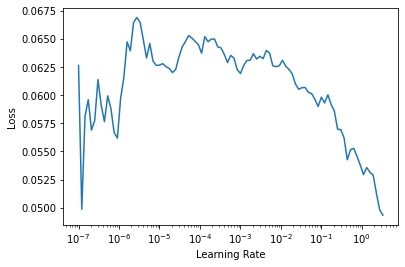

In [70]:
learn.lr_find()

In [71]:
learn.fit_one_cycle(5, lr_max=1e-1)

epoch,train_loss,valid_loss,odds_profit,time
0,0.020095,0.037849,-38.687271,00:06
1,0.042958,0.041267,-42.261276,00:05
2,0.024411,0.019136,-19.561897,00:05
3,0.024238,0.019136,-19.562063,00:06
4,0.021563,0.019136,-19.562115,00:06


In [72]:
preds, _ = learn.get_preds()
preds

tensor([[16.3960, -7.5250, -9.0360],
        [ 7.7649, -8.8138, -6.5815],
        [16.3909, -7.5218, -9.0385],
        ...,
        [ 7.8523, -8.9307, -6.6656],
        [ 7.8636, -8.9483, -6.6763],
        [ 7.8544, -8.9389, -6.6673]])

Appearently the model collapses to set all the money on the home team.